In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# SAM

In [ ]:
# !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
# !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

In [2]:
!pip install ninja

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 3.3 MB/s eta 0:00:00


In [3]:
import os
os.chdir("/content/drive/MyDrive/SAM")

In [4]:
from argparse import Namespace
import os
import sys
import pprint
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

sys.path.append(".")
sys.path.append("..")

from datasets.augmentations import AgeTransformer
from utils.common import tensor2im
# from models.psp import pSp

In [5]:
EXPERIMENT_DATA_ARGS = {
    "ffhq_aging": {
        "model_path": "/content/drive/MyDrive/checkpoints/iteration_48000.pt",
        "image_path": "/content/drive/MyDrive/celebA/Copy of 113.jpg",
        "transform": transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    }
}

In [6]:
EXPERIMENT_TYPE = 'ffhq_aging'
EXPERIMENT_ARGS = EXPERIMENT_DATA_ARGS[EXPERIMENT_TYPE]

In [7]:
# model_path = EXPERIMENT_ARGS['model_path']
# ckpt = torch.load(model_path, map_location='cpu')

In [8]:
# opts = ckpt['opts']
# opts['checkpoint_path'] = model_path
# pprint.pprint(opts)

In [9]:
# opts = Namespace(**opts)
# net = pSp(opts)
# net.eval()
# net.cuda()
# print('Model successfully loaded!')

In [10]:
#Load the SAM model
net = torch.load('/content/drive/MyDrive/pretrained_models/SAM_GF.pt')
net.eval()
net.cuda()
print('Model successfully loaded!')

Model successfully loaded!


In [11]:
def run_alignment(image_path):
    import dlib
    from scripts.align_all_parallel import align_face
    predictor = dlib.shape_predictor("/content/drive/MyDrive/pretrained_models/shape_predictor_68_face_landmarks.dat")
    aligned_image = align_face(filepath=image_path, predictor=predictor)
    print("Aligned image has shape: {}".format(aligned_image.size))
    return aligned_image

In [12]:
image_path = EXPERIMENT_DATA_ARGS[EXPERIMENT_TYPE]["image_path"]
original_image = Image.open(image_path).convert("RGB")

In [13]:
def run_on_batch(inputs, net):
    result_batch = net(inputs.to("cuda").float(), randomize_noise=False, resize=False)
    return result_batch

**Frontlization**

In [14]:
#Load the Frontlization model
model = torch.load('/content/drive/MyDrive/pretrained_models/frontalization.pt')
model.eval()

pSp(
  (encoder): GradualStyleEncoder(
    (input_layer): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=64)
    )
    (body): Sequential(
      (0): bottleneck_IR_SE(
        (shortcut_layer): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
        (res_layer): Sequential(
          (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (2): PReLU(num_parameters=64)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): SEModule(
            (avg_pool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2

In [15]:
# for each age transformed age, we'll concatenate the results to display them side-by-side
def predict(age, gender, frontalize):
  if frontalize == 'no':
      image_path = EXPERIMENT_DATA_ARGS[EXPERIMENT_TYPE]["image_path"]
      original_image = Image.open(image_path).convert("RGB")

      aligned_image = run_alignment(image_path)
      aligned_image.resize((256, 256))

      img_transforms = EXPERIMENT_ARGS['transform']
      input_image = img_transforms(aligned_image)

  else:
      image_path = EXPERIMENT_DATA_ARGS[EXPERIMENT_TYPE]["image_path"]
      original_image = Image.open(image_path).convert("RGB")

      aligned_image = run_alignment(image_path)
      aligned_image.resize((256, 256))

      img_transforms = EXPERIMENT_ARGS['transform']
      transformed_image = img_transforms(aligned_image)
      result_image = model(transformed_image.unsqueeze(0).to("cuda").float())[0]
      output_image = tensor2im(result_image)
      plt.imshow(output_image)
      plt.axis('off')
      plt.savefig('/content/drive/MyDrive/deploy-ML-model-with-webapp/static/Frontalized_img/'+EXPERIMENT_DATA_ARGS[EXPERIMENT_TYPE]["image_path"].split('/')[-1])

      image_path = '/content/drive/MyDrive/deploy-ML-model-with-webapp/static/Frontalized_img/'+EXPERIMENT_DATA_ARGS[EXPERIMENT_TYPE]["image_path"].split('/')[-1]
      original_image = Image.open(image_path).convert("RGB")

      f_aligned_image = run_alignment(image_path)
      f_aligned_image.resize((256, 256))

      img_transforms = EXPERIMENT_ARGS['transform']
      input_image = img_transforms(f_aligned_image)

  if age <= '-1':
    # we'll run the image on multiple target ages
    target_ages = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
  else:
    target_ages = [age]

  age_transformers = [AgeTransformer(target_age=age) for age in target_ages]
  results = np.array(aligned_image.resize((1024, 1024)))
  if gender == '1':
    gender = 1
  else:
    gender = 0
  for age_transformer in age_transformers:
      print(f"Running on target age: {age_transformer.target_age}")
      with torch.no_grad():
          input_image_gender = torch.cat((input_image,gender*torch.ones((1, input_image.shape[1], input_image.shape[2]))))
          input_image_age = [age_transformer(input_image_gender.cpu()).to('cuda')]
          input_image_age = torch.stack(input_image_age)
          result_tensor = run_on_batch(input_image_age, net)[0]
          result_image = tensor2im(result_tensor)
          results = np.concatenate([results, result_image], axis=1)
  print("formating")
  results = Image.fromarray(results)
  print(type(results))
  print('finished')
  return results

In [16]:
########editing

# for each age transformed age, we'll concatenate the results to display them side-by-side
def predict(age, gender, frontalize, STYLE_MIXING):
  if frontalize == 'no':
      image_path = EXPERIMENT_DATA_ARGS[EXPERIMENT_TYPE]["image_path"]
      original_image = Image.open(image_path).convert("RGB")

      aligned_image = run_alignment(image_path)
      aligned_image.resize((256, 256))

      img_transforms = EXPERIMENT_ARGS['transform']
      input_image = img_transforms(aligned_image)

  else:
      image_path = EXPERIMENT_DATA_ARGS[EXPERIMENT_TYPE]["image_path"]
      original_image = Image.open(image_path).convert("RGB")

      aligned_image = run_alignment(image_path)
      aligned_image.resize((256, 256))

      img_transforms = EXPERIMENT_ARGS['transform']
      transformed_image = img_transforms(aligned_image)
      result_image = model(transformed_image.unsqueeze(0).to("cuda").float())[0]
      output_image = tensor2im(result_image)
      plt.imshow(output_image)
      plt.axis('off')
      plt.savefig('/content/drive/MyDrive/deploy-ML-model-with-webapp/static/Frontalized_img/'+EXPERIMENT_DATA_ARGS[EXPERIMENT_TYPE]["image_path"].split('/')[-1])

      image_path = '/content/drive/MyDrive/deploy-ML-model-with-webapp/static/Frontalized_img/'+EXPERIMENT_DATA_ARGS[EXPERIMENT_TYPE]["image_path"].split('/')[-1]
      original_image = Image.open(image_path).convert("RGB")

      f_aligned_image = run_alignment(image_path)
      f_aligned_image.resize((256, 256))

      img_transforms = EXPERIMENT_ARGS['transform']
      input_image = img_transforms(f_aligned_image)

  if '-' in age:
    # we'll run the image on multiple target ages
    target_ages = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
  else:
    target_ages = [age]

  age_transformers = [AgeTransformer(target_age=age) for age in target_ages]
  results = np.array(aligned_image.resize((1024, 1024)))
  if gender == '1':
    gender = 1
  else:
    gender = 0

  if STYLE_MIXING == 'yes' and '-' not in age:
    size_ = len(target_ages)
    multi_modal=[]
    multi_modal.append(results.copy())
    outputs_n=4
    for i in range(0,outputs_n):
      multi_modal[-1] = np.concatenate([multi_modal[-1], results], axis=0)
    for idx, age_transformer in enumerate(age_transformers):
        print(f"Running on target age: {age_transformer.target_age}")
        with torch.no_grad():

            input_image_gender = torch.cat((input_image,gender*torch.ones((1, input_image.shape[1], input_image.shape[2]))))
            input_image_age = [age_transformer(input_image_gender.cpu()).to('cuda')]
            input_image_age = torch.stack(input_image_age)
            result_tensor = run_on_batch(input_image_age, net)[0]
            result_image = tensor2im(result_tensor)
            multi_modal.append(result_image)
            # multi_modal[-1] = np.concatenate([multi_modal[-1], result_image], axis=1)

            # generate random vectors to inject into input image
            vecs_to_inject = np.random.randn(outputs_n, 512).astype('float32')
            multi_modal_outputs = []
            latent_mask = [8,9]
            for vec_to_inject in vecs_to_inject:
              cur_vec = torch.from_numpy(vec_to_inject).unsqueeze(0).to("cuda")
              # get latent vector to inject into our input image
              _, latent_to_inject = net(cur_vec,
                                        input_code=True,
                                        return_latents=True)
              # get output image with injected style vector
              res = net(input_image_age.to("cuda").float(),
                        latent_mask=latent_mask,
                        inject_latent=latent_to_inject,
                        alpha=0.7)

              result_image_style = tensor2im(res[0])
              multi_modal[-1] = np.concatenate([multi_modal[-1], np.array(result_image_style.resize((1024,1024)))], axis=0)
    results = multi_modal[0]
    for img in multi_modal[1:]:
      results = np.concatenate([results, img], axis=1)

    print("formating")
    results = Image.fromarray(results)
    print(type(results))
    print('finished')
    return results

  else:
    for age_transformer in age_transformers:
      print(f"Running on target age: {age_transformer.target_age}")
      with torch.no_grad():
          input_image_gender = torch.cat((input_image,gender*torch.ones((1, input_image.shape[1], input_image.shape[2]))))
          input_image_age = [age_transformer(input_image_gender.cpu()).to('cuda')]
          input_image_age = torch.stack(input_image_age)
          result_tensor = run_on_batch(input_image_age, net)[0]
          result_image = tensor2im(result_tensor)
          results = np.concatenate([results, result_image], axis=1)
    print("formating")
    results = Image.fromarray(results)
    print(type(results))
    print('finished')
    return results

# Video

In [17]:
import imageio
from tqdm import tqdm
import matplotlib
from IPython.display import HTML
from base64 import b64encode

matplotlib.use('module://ipykernel.pylab.backend_inline')
%matplotlib inline


def generate_mp4(out_name, images, kwargs):
    writer = imageio.get_writer(out_name + '.mp4', **kwargs)
    for image in images:
        writer.append_data(image)
    writer.close()


def run_on_batch_to_vecs(inputs, net):
    _, result_batch = net(inputs.to("cuda").float(), return_latents=True, randomize_noise=False, resize=False)
    return result_batch.cpu()


def get_result_from_vecs(vectors_a, vectors_b, alpha):
    results = []
    for i in range(len(vectors_a)):
        cur_vec = vectors_b[i] * alpha + vectors_a[i] * (1 - alpha)
        res = net(cur_vec.cuda(), randomize_noise=False, input_code=True, input_is_full=True, resize=False)
        results.append(res[0])
    return results


def show_mp4(filename, width=400):
    mp4 = open(filename + '.mp4', 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display(HTML("""
    <video width="%d" controls autoplay loop>
        <source src="%s" type="video/mp4">
    </video>
    """ % (width, data_url)))

In [18]:
SEED = 42
np.random.seed(SEED)

img_transforms = EXPERIMENT_ARGS['transform']
n_transition = 25
kwargs = {'fps': 40}
save_path = "/content/drive/MyDrive/deploy-ML-model-with-webapp/static/video"
os.makedirs(save_path, exist_ok=True)

In [19]:
root_dir = '/content/drive/MyDrive/deploy-ML-model-with-webapp/static'
ims = ['m1.png','mm2.jpg']
im_paths = [os.path.join(root_dir, im) for im in ims]

In [20]:
target_ages = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 90, 80, 70, 60, 50, 40, 30, 20, 10, 0]
age_transformers = [AgeTransformer(target_age=age) for age in target_ages]

In [21]:
def animate(title, im_pathe):
  gender=0
  for image_path in im_pathe:
      image_name = os.path.basename(image_path)
      print(f'Working on image: {image_name}')
      original_image = run_alignment(image_path)


      # original_image = Image.open(image_path).convert("RGB")
      input_image = img_transforms(original_image)
      all_vecs = []
      for idx, age_transformer in enumerate(age_transformers):
          input_image_gender = torch.cat((input_image,gender*torch.ones((1, input_image.shape[1], input_image.shape[2]))))

          input_age_batch = [age_transformer(input_image_gender.cpu()).to('cuda')]
          input_age_batch = torch.stack(input_age_batch)


          # get latent vector for the current target age amount
          with torch.no_grad():
              result_vec = run_on_batch_to_vecs(input_age_batch, net)
              result_image = get_result_from_vecs([result_vec], result_vec, 0)[0]
              all_vecs.append([result_vec])

      images = []
      for i in range(1, len(target_ages)):
          alpha_vals = np.linspace(0, 1, n_transition).tolist()
          for alpha in tqdm(alpha_vals):
              result_image = get_result_from_vecs(all_vecs[i-1], all_vecs[i], alpha)[0]
              output_im = tensor2im(result_image)
              images.append(np.array(output_im))

      animation_path = os.path.join(save_path, f"{title}_animation")
      generate_mp4(animation_path, images, kwargs)
      # show_mp4(animation_path)

# Flask BackEnd

In [22]:
# !git clone https://github.com/datamagic2020/deploy-ML-model-with-webapp.git

In [23]:
!pip install flask-ngrok
!pip install pyngrok==4.1.1
!ngrok authtoken 2Ry6fE16AT67XQuYsXZb5Jb1FIP_4A2H44DUmyuh23SMQzrjW

  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-4.1.1-py3-none-any.whl size=15963 sha256=c15a4d154fb4a85f101c2e614fd9acef66a361df29ef59f2c11ca1555ec10f39
  Stored in directory: /root/.cache/pip/wheels/4c/7c/4c/632fba2ea8e88d8890102eb07bc922e1ca8fa14db5902c91a8
Successfully built pyngrok
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [24]:
from flask_ngrok import run_with_ngrok
import pickle
import numpy as np
from flask import Flask, flash, request, redirect, url_for, render_template
import urllib.request
import os
from werkzeug.utils import secure_filename
from PIL import Image
import io

In [25]:
from matplotlib import pyplot as plt

In [26]:
cd /content/drive/MyDrive/deploy-ML-model-with-webapp

/content/drive/.shortcut-targets-by-id/1213fLGyo-Yp-W97KaHRr8HOB6e0YD8aX/deploy-ML-model-with-webapp


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://a486-34-123-175-244.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [05/Aug/2023 17:46:29] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [05/Aug/2023 17:46:34] "GET /static/static_img/ai_background.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [05/Aug/2023 17:46:34] "GET /static/static_img/img_girl.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [05/Aug/2023 17:46:37] "GET /favicon.ico HTTP/1.1" 404 -


Aligned image has shape: (256, 256)
Aligned image has shape: (256, 256)
Running on target age: 50
formating
<class 'PIL.Image.Image'>
finished


INFO:werkzeug:127.0.0.1 - - [05/Aug/2023 17:47:14] "POST /face-age HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [05/Aug/2023 17:47:14] "GET /static/Generated_img/messi_in500yes_age_transformed_image.jpg HTTP/1.1" 200 -


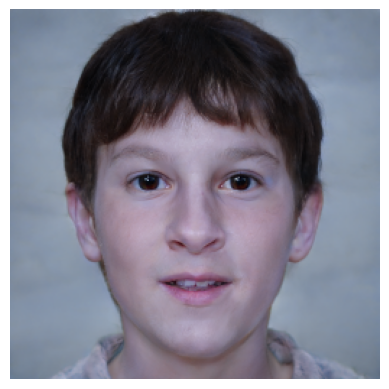

In [27]:
app = Flask(__name__)
run_with_ngrok(app)
@app.route('/')
def home():
    return render_template('index.html')

app.secret_key = "secret key"
app.config['UPLOAD_FOLDER'] = '/content/drive/MyDrive/deploy-ML-model-with-webapp/static/Input_img/'
app.config['MAX_CONTENT_LENGTH'] = 16 * 1024 * 1024

ALLOWED_EXTENSIONS = set(['png', 'jpg', 'jpeg', 'gif'])

def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS


@app.route('/face-age', methods=['POST'])
def face_age():
    if 'input_image' not in request.files:
        flash('No file part')
        return redirect(request.url)
    file = request.files['input_image']
    if file.filename == '':
        flash('No image selected for uploading')
        return redirect(request.url)
    if file and allowed_file(file.filename):

        filename = secure_filename(file.filename)
        file.save(os.path.join(app.config['UPLOAD_FOLDER'], filename))

    else:
        flash('Allowed image types are - png, jpg, jpeg, gif')
        return redirect(request.url)

    age = request.form['input_age']
    gender = request.form['gender']
    frontalize = request.form['frontalization']
    variation = request.form['variations']

    EXPERIMENT_DATA_ARGS[EXPERIMENT_TYPE]["image_path"] = app.config['UPLOAD_FOLDER'] +filename
    try:
       rm = predict(age, gender, frontalize, variation)
    except:
       return '<h1>Could not find face in image go back. Try another!<h1/>'

    f = filename.split('.')
    name = f"/content/drive/MyDrive/deploy-ML-model-with-webapp/static/Generated_img/{f[0] + age + gender + frontalize}_age_transformed_image.jpg"
    rm.save(name)
    output = plt.imread(name)
    name = f"Generated_img/{f[0] + age + gender + frontalize}_age_transformed_image.jpg"

    if '-' in age:
    #animate
        video = "video/m1.png_animation.mp4"
        if frontalize == 'yes':
          ims = ['Frontalized_img/'+EXPERIMENT_DATA_ARGS[EXPERIMENT_TYPE]["image_path"].split('/')[-1]]
        else:
          ims = [name]
        im_paths = [os.path.join(root_dir, im) for im in ims]
        # print(im_paths)
        title=f[0]
        animate(title, im_paths)
    #/animate
        ######################

        #####################
        video=f"video/{title}_animation.mp4"
        return render_template('generated.html', output_image = name, vid = video)

    else:
      return render_template('generated.html', output_image = name)

app.run()